# Gradiometry Simulation

In [1]:
import magpylib as magpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import random
from scipy.signal import chirp
import scipy.spatial.transform as st


Functions to load noise

In [22]:
def noiseReactionWheel(fs, N, base_freq, seed):
    np.random.seed(seed) 
    shift_freq = np.random.uniform(1, base_freq)
    duration = int(np.random.uniform(1, 5))
    time_of_shift = np.random.randint(0, (N/fs) - (2*duration))

    # Define time array.
    t = np.arange(N) / fs

    # Create signal.
    signal_rw = np.sin(2 * np.pi * base_freq * t)

    # Create down-chirp signal.
    down_chirp_signal = chirp(t[:duration*fs], base_freq, duration, shift_freq, method='hyperbolic')
    # Create up-chirp signal
    up_chirp_signal = chirp(t[:duration*fs], shift_freq, duration, base_freq, method='hyperbolic')

    # Modify original signal with chirp signal.
    signal_rw[time_of_shift*fs:(time_of_shift+duration)*fs] = down_chirp_signal
    signal_rw[(time_of_shift+duration)*fs:(time_of_shift+2*duration)*fs] = up_chirp_signal

    return signal_rw

def noiseMichibiki():
    "Import the magnetometer data from the file"
    qzs_1 = np.loadtxt(r"utility\SPACE_DATA\michibiki.dat", dtype=float, usecols=(0,4,5,6,7,8,9))
    B_qzs = qzs_1.T

    "Subtract the bias from the magnetometer data"
    B_qzs[1] -= 60 # MAM-S1 X-Axis
    B_qzs[2] -= 410 # MAM-S1 Y-Axis
    B_qzs[3] -= -202 # MAM-S1 Z-Axis
    B_qzs[4] -= -528 # MAM-S2 X-Axis
    B_qzs[5] -= -200 # MAM-S2 Y-Axis
    B_qzs[6] -= 478 # MAM-S2 Z-Axis

    Bx = B_qzs[4] - B_qzs[1]
    By = B_qzs[5] - B_qzs[2]
    Bz = B_qzs[6] - B_qzs[3]
    michibiki = np.vstack((Bx,By,Bz))
    return(michibiki)

def noiseArcjet(N, seed = 0):
    # Defining a function that takes an integer N and an optional integer seed as parameters
    "Randomly Turn on and off signals" # A docstring that describes the function
    f = 500 # Setting a constant f
    np.random.seed(seed) # Setting the random seed for reproducibility
    zeros_ = np.random.choice([0, 1], size=(N // f + 1,), p=[3./10, 7./10]) # Generating an array of 0's and 1's with a 10% chance of 0 and a 90% chance of 1, with a size of N // f + 1
    ones_ = np.ones(N) # Generating an array of 1's with a size of N
    for i in range(N//f + 1): # Looping through the indices of the zeros_ array
        if(zeros_[i] == 1): # If the element at the current index is 1
            ones_[i*f:min((i+1)*f, N)] = 0 # Set the corresponding f elements or the remaining elements in the ones_ array to 0
    return(ones_) # Return the ones_ array as the output

def createMixingMatrix(seed, axis = 0):
    random.seed(seed)
    np.random.seed(seed)

    "Create Sensors"
    s1 = magpy.Sensor(position=(0,0,.300), style_size=1.8)
    s2 = magpy.Sensor(position=(0,0,000), style_size=1.8)
    s3 = magpy.Sensor(position=(0.04,.04,.04), style_size=1.8)
    s = [s1,s2]
    
    "Create Sources"
    d1 = magpy.current.Loop(current=150, diameter=.010, orientation=st.Rotation.random(),  position=(random.uniform(-.035, .035), random.uniform(-.035, .035), random.uniform(.015, .285)))
    d2 = magpy.current.Loop(current=150, diameter=.010, orientation=st.Rotation.random(), position=(random.uniform(-.035, .035), random.uniform(-.035, .035), random.uniform(.015, .285)))    
    d3 = magpy.current.Loop(current=150, diameter=.010, orientation=st.Rotation.random(), position=(random.uniform(-.035, .035), random.uniform(-.035, .035), random.uniform(.015, .285)))
    d4 = magpy.current.Loop(current=150, diameter=.010, orientation=st.Rotation.random(), position=(random.uniform(-.035, .035), random.uniform(-.035, .035), random.uniform(.015, .285)))  
    src = [d1,d2,d3,d4]

    mixingMatrix = np.zeros((5,len(s)))
    mixingMatrix[0] = np.ones(len(s))

    for i in range(len(src)):
        mixing_vector = (src[i].getB(s)*1e9).T[axis]
        mixingMatrix[i+1] = mixing_vector

    return(mixingMatrix.T)

def randomizeSignals(N, seed = 0):
    # Defining a function that takes an integer N and an optional integer seed as parameters
    "Randomly Turn on and off signals" # A docstring that describes the function
    f = 300 # Setting a constant f to 300
    np.random.seed(seed) # Setting the random seed for reproducibility
    zeros_ = np.random.choice([0, 1], size=(N // f + 1,), p=[1./10, 9./10]) # Generating an array of 0's and 1's with a 10% chance of 0 and a 90% chance of 1, with a size of N // f + 1
    ones_ = np.ones(N) # Generating an array of 1's with a size of N
    for i in range(N//f + 1): # Looping through the indices of the zeros_ array
        if(zeros_[i] == 1): # If the element at the current index is 1
            ones_[i*f:min((i+1)*f, N)] = 0 # Set the corresponding f elements or the remaining elements in the ones_ array to 0
    return(ones_) # Return the ones_ array as the output

def snr(x, y):
  # x and y are numpy arrays of the same length
  # x is the original signal and y is the noisy signal
  # returns the SNR in decibels
  x_mean = np.mean(x) # calculate the mean of x
  num = np.sum((x - x_mean)**2) # calculate the numerator of SNR
  den = np.sum((x - y)**2) # calculate the denominator of SNR
  if den == 0: # avoid division by zero
    return np.inf # return infinity if denominator is zero
  else:
    return 10 * np.log10(num / den) # return SNR in decibels



Load Satellite Data

In [6]:
duration = 100; sampleRate = 50; N = duration*sampleRate; T = 1/sampleRate
samples = np.linspace(0, duration, N, endpoint=False)
signals = np.zeros((5, samples.shape[0]))

"Import ambient magnetic field signal."
df=pd.read_csv(r'utility\SPACE_DATA\Swarm_MAGA_HR_20150317_0900.csv', sep=',',header=None)
r = df[10]
swarm = np.array([np.fromstring(r[i][1:-1], dtype=float, sep=' ') for i in range(1, r.shape[0])]).T[:,160000:160000+N]

"Import Michibiki Data"
michibiki = noiseMichibiki()

C:\Users\Alex\AppData\Local\Temp\ipykernel_22700\4184457849.py:6: DtypeWarning: Columns (2,5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(r'utility\SPACE_DATA\Swarm_MAGA_HR_20150317_0900.csv', sep=',',header=None)


Create Source and Mixed Signals

In [28]:
i = 3
random.seed(i)
np.random.seed(i)

n = random.randint(0, michibiki.shape[-1]-5000)

"Create Source Signals"
signals[0] = 10*np.sin(2 * np.pi * .3 * samples) 
signals[1] = np.sin(2 * np.pi * 1.2 * samples)
signals[2] = 0*np.sin(2 * np.pi * 1 * samples)
signals[3] = 0*noiseArcjet(N, i) # Arcjet
signals[4] = 0*signal.sawtooth(2 * np.pi * 3 * samples)*randomizeSignals(N,random.randint(0,100000))

"Create Mixing Matrices"
Kx = createMixingMatrix(i, 0)
Ky = createMixingMatrix(i, 1)
Kz = createMixingMatrix(i, 2)

"Create Mixed Signals"
Bx = Kx @ signals

signals[0] = np.sin(2 * np.pi * 3 * samples) 
signals[2] = 0*(michibiki[1][n:n+5000]-np.mean(michibiki[1][n:n+5000]))/np.max(np.abs((michibiki[1][n:n+5000]-np.mean(michibiki[1][n:n+5000]))))
By = Ky @ signals

signals[0] = np.sin(2 * np.pi * 3 * samples) 
signals[2] = 0*(michibiki[2][n:n+5000]-np.mean(michibiki[2][n:n+5000]))/np.max(np.abs((michibiki[2][n:n+5000]-np.mean(michibiki[2][n:n+5000]))))
Bz = Kz @ signals

"Create B"
B = np.array([Bx,By,Bz])
B = np.swapaxes(B,0,1)


c:\ProgramData\Anaconda3\lib\site-packages\magpylib\_src\obj_classes\class_current_Circle.py:143: MagpylibDeprecationWarning: Loop is deprecated  and will be removed in a future version, use Circle instead.
  _deprecation_warn()
c:\ProgramData\Anaconda3\lib\site-packages\magpylib\_src\obj_classes\class_current_Circle.py:139: MagpylibDeprecationWarning: Loop is deprecated  and will be removed in a future version, use Circle instead.
  _deprecation_warn()


In [27]:
np.set_printoptions(precision=3)
print(np.round(Kx,4)) 
print(np.round(Ky,4)) 
print(np.round(Kz,4)) 

"Normalize Kx, Ky, Kz per column"
Kx = Kx / np.linalg.norm(Kx, axis=0)
Ky = Ky / np.linalg.norm(Ky, axis=0)
Kz = Kz / np.linalg.norm(Kz, axis=0)
print(np.round(Kx,5)) 
print(np.round(Ky,5)) 
print(np.round(Kz,5)) 

[[ 5.774e-01  4.930e-02 -2.810e-02  3.460e-02  3.000e-04]
 [ 5.774e-01  2.900e-03 -2.900e-03  1.800e-03  2.900e-03]
 [ 5.774e-01  9.988e-01 -9.996e-01 -9.994e-01  1.000e+00]]
[[ 5.774e-01 -2.175e-01  2.000e-03 -5.900e-02  7.218e-01]
 [ 5.774e-01 -1.220e-02  2.000e-04 -3.700e-03 -1.300e-03]
 [ 5.774e-01 -9.760e-01  1.000e+00 -9.982e-01 -6.921e-01]]
[[ 5.774e-01 -2.340e-02  1.770e-02  9.549e-01 -7.000e-01]
 [ 5.774e-01 -2.000e-04  1.900e-03  8.560e-02 -3.080e-02]
 [ 5.774e-01 -9.997e-01 -9.998e-01  2.844e-01 -7.135e-01]]
[[ 5.774e-01  4.929e-02 -2.812e-02  3.455e-02  2.600e-04]
 [ 5.774e-01  2.870e-03 -2.900e-03  1.840e-03  2.890e-03]
 [ 5.774e-01  9.988e-01 -9.996e-01 -9.994e-01  1.000e+00]]
[[ 5.774e-01 -2.175e-01  2.000e-03 -5.902e-02  7.218e-01]
 [ 5.774e-01 -1.224e-02  2.200e-04 -3.710e-03 -1.270e-03]
 [ 5.774e-01 -9.760e-01  1.000e+00 -9.982e-01 -6.921e-01]]
[[ 5.774e-01 -2.336e-02  1.768e-02  9.549e-01 -7.000e-01]
 [ 5.774e-01 -2.200e-04  1.890e-03  8.558e-02 -3.082e-02]
 [ 5.774e

Clean Data

In [6]:
from algorithms import SHEINKER


SHEINKER.uf = 500
SHEINKER.detrend = True

B_clean = SHEINKER.clean(np.copy(B))

rmse = np.sqrt(((swarm.T-B_clean.T)**2).mean(axis=0))
corr = np.zeros(3); snr_ = np.zeros(3)
for j in range(3):
    corr[j] = np.corrcoef(swarm[j], B_clean[j])[0,1]
    snr_[j] = snr(swarm[j], B_clean[j])

print("RMSE: ", rmse)
print("Correlation: ", corr)
print("SNR: ", snr_)

RMSE:  [59.15533216 68.46214281 98.15590339]
Correlation:  [0.99015915 0.97697193 0.91381643]
SNR:  [12.19954303 10.34045574 -4.5453319 ]


Text(0.5, 1.0, 'Cleaned Magnetic Field Data')

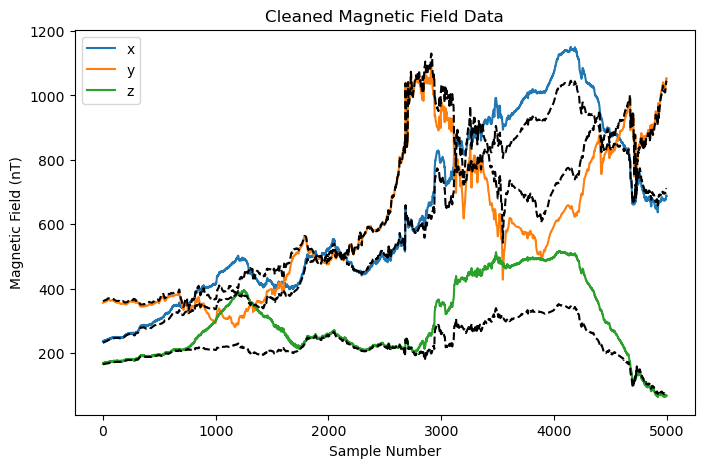

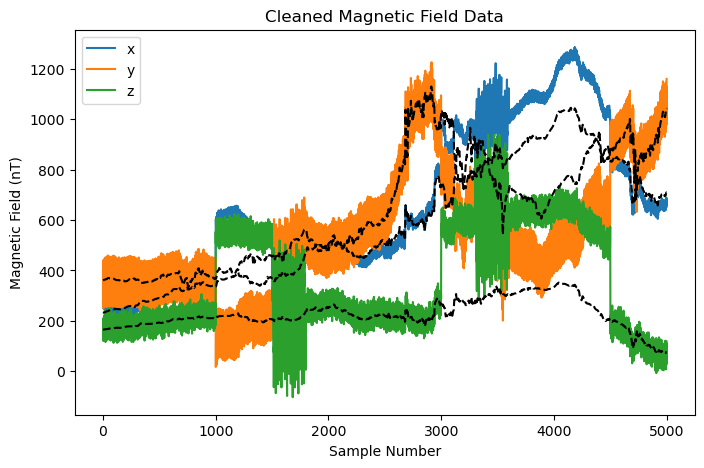

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

plt.plot(B_clean.T, label=['x','y','z'])
plt.plot(swarm.T, color = 'black', linestyle = '--')
plt.xlabel("Sample Number"); plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.title("Cleaned Magnetic Field Data")


fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(B[0].T, label=['x','y','z'])
plt.plot(swarm.T, color = 'black', linestyle = '--')
plt.xlabel("Sample Number"); plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.title("Noisy Magnetic Field Data")